In [773]:
import numpy as np
from scipy.stats import multivariate_normal
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7,7)

(-9.0, 9.0)

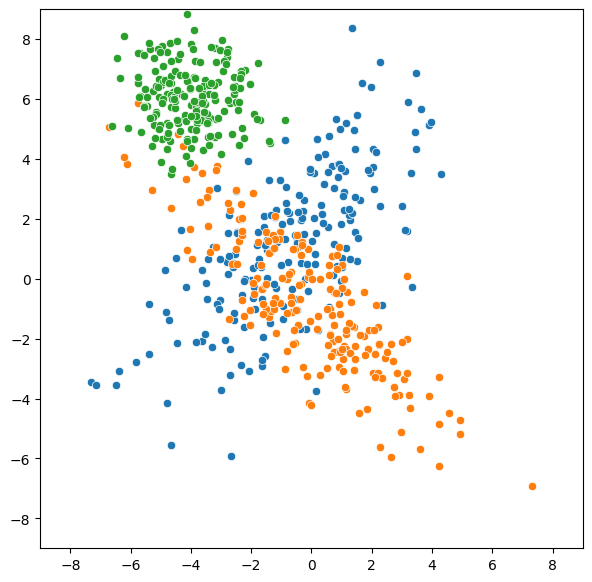

In [774]:
GROUP_SIZE = 200
rng = np.random.default_rng(4329)
group1 = rng.multivariate_normal((-1,1),((6,4),(4,6)),size = GROUP_SIZE) # mean, cov
group2 = rng.multivariate_normal((0,-1),((5,-4),(-4,5)),size = GROUP_SIZE)
group3 = rng.multivariate_normal((-4,6),((1,0),(0,1)),size = GROUP_SIZE)
groups = [group1,group2,group3]
data = np.concatenate(groups,axis=0)
for group in groups:
    sns.scatterplot(x = group[:,0], y = group[:,1])
plt.xlim(-9,9)
plt.ylim(-9,9)

In [775]:
def random_multivariate_normal(rng, mean_range, x_var_range, y_var_range):
    mean = rng.uniform(mean_range[0],mean_range[1],size = (1,2))
    x_var = rng.uniform(*x_var_range)
    y_var = rng.uniform(*y_var_range)
    max_cov=np.sqrt(np.abs(x_var*y_var))
    cov = rng.uniform(-max_cov,max_cov)
    cov_mat = np.array([[x_var,cov],[cov,y_var]])
    return np.concatenate((mean,cov_mat),axis=0)

g1 = random_multivariate_normal(rng,(-5,5),(0,10),(0,10))   
g2 = random_multivariate_normal(rng,(-5,5),(0,10),(0,10))
g3 = random_multivariate_normal(rng,(-5,5),(0,10),(0,10))
gaussians = [g1,g2,g3]
pis = np.ones(len(gaussians))/len(gaussians)
alphas = (1.,0.5,0.5)
colors = ("Greens", "Blues", "Reds")
f= lambda x, y, g: multivariate_normal(g[0],g[1:],allow_singular=True).pdf(np.dstack((x,y)))
g1,g2,g3

(array([[-4.30830834,  3.47926687],
        [ 0.79172889,  0.73688885],
        [ 0.73688885,  6.372777  ]]),
 array([[ 4.90194065,  3.58925651],
        [ 6.03339871, -1.73855665],
        [-1.73855665,  8.71922269]]),
 array([[ 3.69890087, -4.57783723],
        [ 7.43905947, -4.97249519],
        [-4.97249519,  4.7425481 ]]))

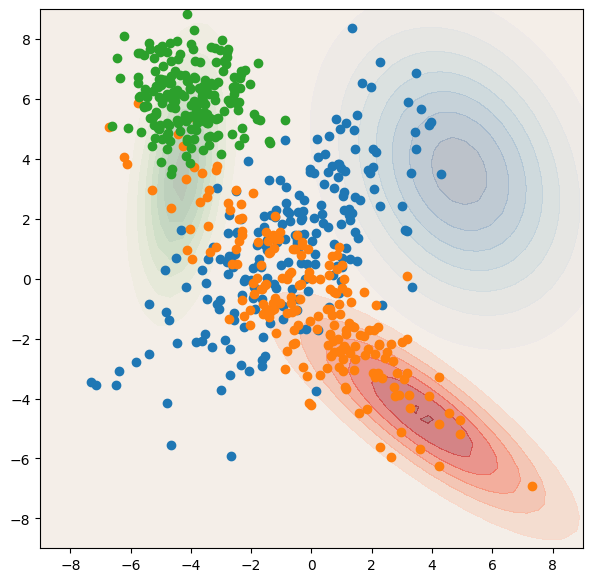

In [776]:
def plot_gaussians(gaussians,pis, alphas, colors,groups):
    x_lin = np.linspace(-10,10)
    xx, yy = np.meshgrid(x_lin,x_lin)
    for g, pi, alpha, color in zip(gaussians, pis, alphas, colors):
        plt.contourf(xx,yy,f(xx,yy,g),alpha=alpha,cmap=color)
    for group in groups:
        plt.scatter(group[:,0],group[:,1])
    plt.xlim(-9,9)
    plt.ylim(-9,9)
plot_gaussians(gaussians,pis, alphas, colors,groups)

99


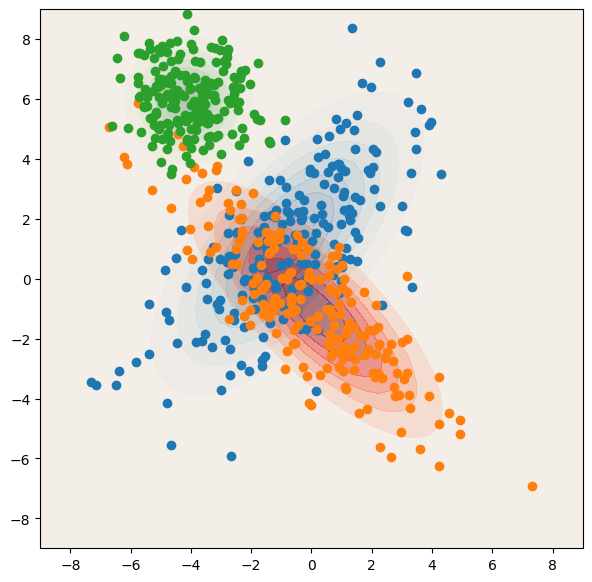

In [777]:
def ratios(data,gaussians, pis):
    probas = []
    for g, pi in zip(gaussians, pis):
        probas.append(pi*f(data[:,0],data[:,1],g))
    probas = np.stack(probas, axis=1)
    ratio = probas / probas.sum(axis=1, keepdims=True)
    return ratio


def exp_mean_cov(data, ratio):
    m = (data*ratio).sum(axis=0) / ratio.sum()
    cov =  (data-m).T@(ratio*(data - m))/ratio.sum()
    return np.concatenate((m[np.newaxis,...],cov),axis=0)

for i in range(100):
    prev_gaussians = [g.copy() for g in gaussians]
    r = ratios(data,gaussians, pis)
    pis = r.mean(axis=0)
    gaussians = [exp_mean_cov(data,r[:,i][...,np.newaxis]) for i in range(r.shape[1])]
    # if np.abs(prev_g1-g1).sum() + np.abs(prev_g2-g2).sum() < 0.01:
    #     break

plot_gaussians(gaussians,pis, alphas, colors,groups)
print(i)

In [797]:
print(np.arccos(np.linalg.eig(g1[1:])[1][0,0]))
print(np.arcsin(np.linalg.eig(g1[1:])[1][1,0]))

3.012505186275515
0.1290874673142786


In [787]:
np.linalg.eig(g1[1:])

EigResult(eigenvalues=array([0.69607386, 6.46843202]), eigenvectors=array([[-0.99167978, -0.12872926],
       [ 0.12872926, -0.99167978]]))

In [803]:
from scipy.spatial.transform import Rotation
rot_M = np.linalg.eig(g1[1:])[1]
rot_M = np.concatenate((rot_M,np.zeros((2,1))),axis=1)
rot_M = np.concatenate((rot_M,np.zeros((1,3))),axis=0)
rot_M[2,2] = 1
Rotation.from_matrix(rot_M).as_euler('xyz')

array([0.        , 0.        , 3.01250519])

In [801]:
rot_M

array([[-0.99167978, -0.12872926,  0.        ],
       [ 0.12872926, -0.99167978,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])